Training with constant epsilon...
Time 0.10, Step 0, Loss: 0.073116
Time 0.10, Step 100, Loss: 0.023727
Time 0.10, Step 200, Loss: 0.022739
Time 0.10, Step 300, Loss: 0.097987
Time 0.10, Step 400, Loss: 0.081104
Time 0.10, Step 500, Loss: 0.063455
Time 0.10, Step 600, Loss: 0.053803
Time 0.10, Step 700, Loss: 0.049181
Time 0.10, Step 800, Loss: 0.048151
Time 0.10, Step 900, Loss: 0.040557
Time 0.20, Step 0, Loss: 0.300413
Time 0.20, Step 100, Loss: 0.042199
Time 0.20, Step 200, Loss: 0.034134
Time 0.20, Step 300, Loss: 0.027299
Time 0.20, Step 400, Loss: 0.022093
Time 0.20, Step 500, Loss: 0.018791
Time 0.20, Step 600, Loss: 0.016939
Time 0.20, Step 700, Loss: 0.015462
Time 0.20, Step 800, Loss: 0.015145
Time 0.20, Step 900, Loss: 0.026508
Time 0.30, Step 0, Loss: 0.029395
Time 0.30, Step 100, Loss: 0.015850
Time 0.30, Step 200, Loss: 0.015241
Time 0.30, Step 300, Loss: 0.014372
Time 0.30, Step 400, Loss: 0.014122
Time 0.30, Step 500, Loss: 0.018686
Time 0.30, Step 600, Loss: 0.028610


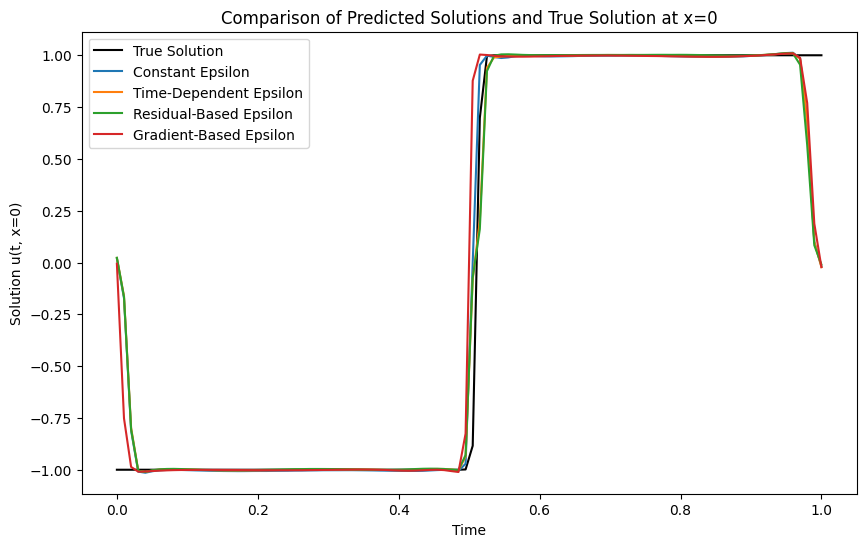

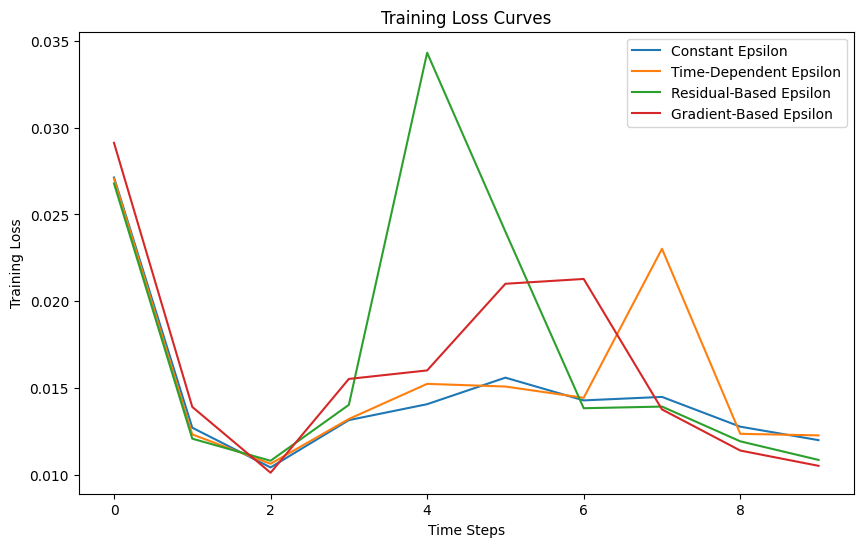

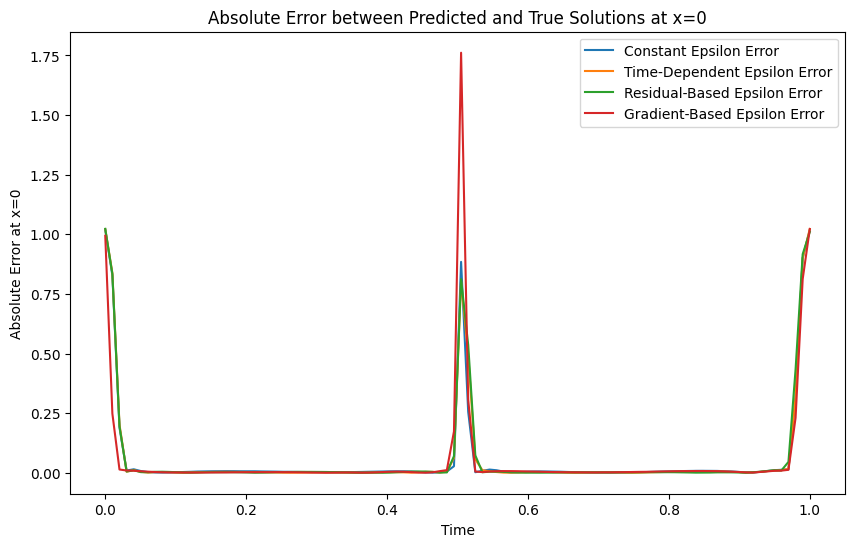

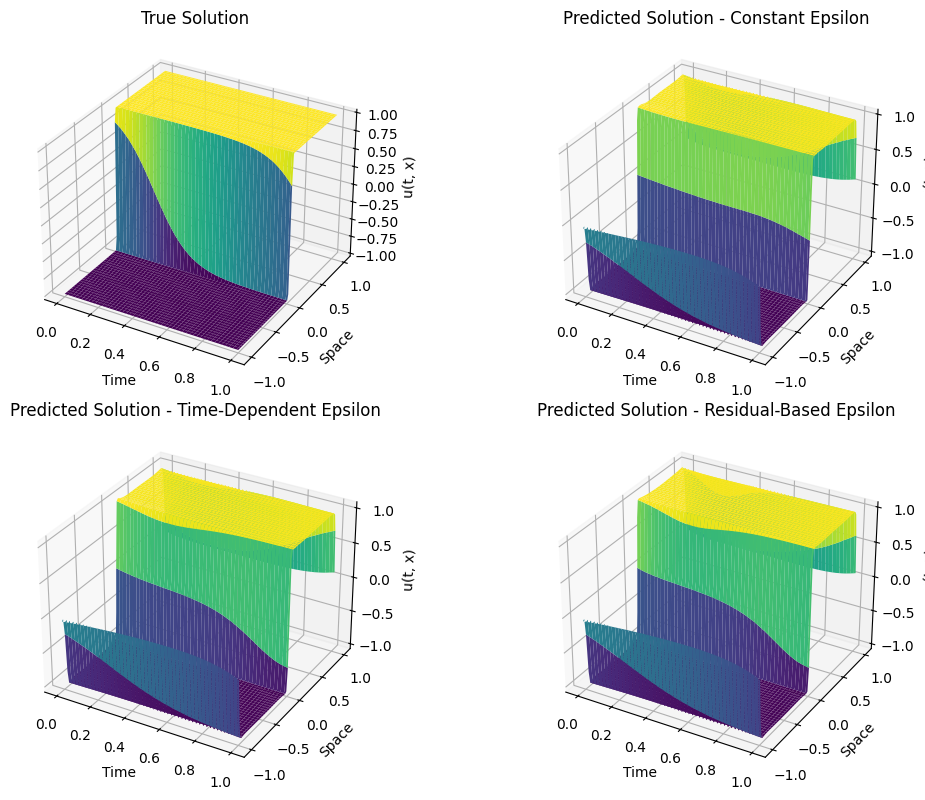

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from functools import partial

# Define the Allen-Cahn equation parameters
alpha = 0.0001
beta = 5.0

# Flax neural network model
class PINN(nn.Module):
    hidden_layers: list

    @nn.compact
    def __call__(self, t, x):
        # Stack t and x to create input features
        inputs = jnp.stack([t, x], axis=-1)
        x = inputs
        for hidden_units in self.hidden_layers:
            x = nn.Dense(hidden_units)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x.squeeze(-1)

# Initialize the model
def create_model(hidden_layers=[64, 64]):
    return PINN(hidden_layers=hidden_layers)

# PDE Residual Loss (Allen-Cahn equation)
def residual_loss(params, model, t, x):
    def model_output(t, x):
        return model(params, t, x)

    u_pred = model_output(t, x)
    u_t = grad(model_output, argnums=0)(t, x)
    u_xx = grad(grad(model_output, argnums=1), argnums=1)(t, x)
    residual = u_t - alpha * u_xx + beta * (u_pred ** 3 - u_pred)
    return residual ** 2

# Boundary loss function
def boundary_loss(params, model, t_boundary, x_boundary):
    u_pred = model(params, t_boundary, x_boundary)
    # Assuming Dirichlet boundary conditions u = 0 at x = -1 and x = 1
    loss = (u_pred) ** 2
    return loss

# Initial condition loss function
def initial_condition_loss(params, model, t0, x0, u0):
    u_pred = model(params, t0, x0)
    loss = (u_pred - u0) ** 2
    return loss

# Adaptive causality weight functions
def epsilon_constant():
    return 0.1  # Constant epsilon value

def epsilon_time_dependent(t, epsilon_0, decay_rate):
    return epsilon_0 * jnp.exp(-decay_rate * t)

def epsilon_residual_based(cumulative_loss, alpha_param, lambda_param):
    return alpha_param / (1 + lambda_param * cumulative_loss)

def epsilon_gradient_based(params, model, t, x, alpha_param, beta_param):
    u_x = grad(lambda x: model(params, t, x))(x)
    return alpha_param * jnp.abs(u_x) + beta_param

# Compute causality weight based on epsilon function
def compute_causality_weight(epsilon, t):
    return jnp.exp(-epsilon * t)

# Reweighted residual loss function
def reweighted_residual_loss(params, model, t_values, x_values, epsilon_func, epsilon_params):
    cumulative_loss = 0.0
    previous_time = 0.0

    def body_fun(carry, inputs):
        cumulative_loss, previous_time = carry
        t_i, x_i = inputs
        delta_t = t_i - previous_time
        single_loss = residual_loss(params, model, t_i, x_i)

        # Accumulate cumulative loss over time
        cumulative_loss += single_loss * delta_t

        # Compute epsilon
        if epsilon_func == epsilon_constant:
            epsilon = epsilon_func()
        elif epsilon_func == epsilon_time_dependent:
            epsilon = epsilon_func(t_i, *epsilon_params)
        elif epsilon_func == epsilon_residual_based:
            epsilon = epsilon_func(cumulative_loss, *epsilon_params)
        elif epsilon_func == epsilon_gradient_based:
            epsilon = epsilon_func(params, model, t_i, x_i, *epsilon_params)
        else:
            raise ValueError("Invalid epsilon function type.")

        weight = compute_causality_weight(epsilon, t_i)
        weighted_loss = weight * single_loss
        previous_time = t_i
        return (cumulative_loss, previous_time), weighted_loss

    # Ensure t_values are sorted
    sorted_indices = jnp.argsort(t_values)
    t_values = t_values[sorted_indices]
    x_values = x_values[sorted_indices]

    # Initialize cumulative_loss and previous_time
    cumulative_loss = 0.0
    previous_time = 0.0

    # Use lax.scan to iterate efficiently
    (_, _), weighted_losses = jax.lax.scan(
        body_fun, (cumulative_loss, previous_time), (t_values, x_values)
    )
    total_loss = jnp.mean(weighted_losses)
    return total_loss

# JIT-compiled version of the reweighted residual loss
jit_reweighted_residual_loss = jit(reweighted_residual_loss, static_argnums=(1, 4, 5))

# Define the training state
class TrainState(train_state.TrainState):
    pass

# Initialize training state
def create_train_state(rng, model, learning_rate):
    # Initialize parameters with sample inputs
    params = model.init(rng, jnp.ones((1,)), jnp.ones((1,)))
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training step with JIT compilation
@partial(jit, static_argnums=(3, 4))
def train_step(state, t_values, x_values, epsilon_func, epsilon_params):
    def loss_fn(params):
        # Compute residual loss
        residual = reweighted_residual_loss(params, state.apply_fn, t_values, x_values, epsilon_func, epsilon_params)

        # Compute boundary loss
        x_boundary_left = -1.0 * jnp.ones_like(t_values)
        x_boundary_right = 1.0 * jnp.ones_like(t_values)
        boundary_left = boundary_loss(params, state.apply_fn, t_values, x_boundary_left)
        boundary_right = boundary_loss(params, state.apply_fn, t_values, x_boundary_right)
        boundary = jnp.mean(boundary_left + boundary_right)

        # Compute initial condition loss
        t0 = jnp.zeros_like(x_values)
        u0 = numerical_solution(t0, x_values)
        initial = jnp.mean(initial_condition_loss(params, state.apply_fn, t0, x_values, u0))

        # Total loss
        total_loss = residual + boundary + initial
        return total_loss

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

# Time-marching training loop
def train_model_time_marching(rng, model, t_values, x_values, epsilon_func, epsilon_params, num_steps=1000, learning_rate=1e-3, num_time_steps=10):
    state = create_train_state(rng, model, learning_rate)
    loss_history = []
    max_time = t_values.max()
    time_steps = jnp.linspace(0, max_time, num_time_steps + 1)[1:]  # Exclude t=0

    for t_end in time_steps:
        # Select data up to current time t_end
        mask = t_values <= t_end
        t_current = t_values[mask]
        x_current = x_values[mask]

        # Training loop for current time interval
        for step in range(num_steps):
            state = train_step(state, t_current, x_current, epsilon_func, epsilon_params)
            if step % 10 == 0:
                loss = reweighted_residual_loss(state.params, state.apply_fn, t_current, x_current, epsilon_func, epsilon_params)
                if step % 100 == 0:
                    print(f"Time {t_end:.2f}, Step {step}, Loss: {loss:.6f}")
        loss_history.append(loss)
    return state, loss_history

# Sample time and space points for training
key = jax.random.PRNGKey(0)
t_values = jax.random.uniform(key, (1000,), minval=0.0, maxval=1.0)
t_values = jnp.sort(t_values)  # Ensure time values are sorted
x_values = jax.random.uniform(key, (1000,), minval=-1.0, maxval=1.0)

# Define epsilon parameters
epsilon_params_constant = ()  # No parameters needed for constant epsilon
epsilon_params_time = (0.1, 2.0)  # epsilon_0, decay_rate
epsilon_params_residual = (0.1, 0.5)
epsilon_params_gradient = (0.1, 0.05)

# Numerical solution of the Allen-Cahn equation for comparison
def numerical_solution(t_values, x_values):
    x0 = 0.0
    v = 2 * jnp.sqrt(alpha * beta)
    solution = jnp.tanh((x_values - x0 - v * t_values) / (2 * jnp.sqrt(alpha / beta)))
    return solution

# Initialize the model
model = create_model(hidden_layers=[64, 64])
rng = jax.random.PRNGKey(42)

# Train with constant epsilon
print("Training with constant epsilon...")
state_constant, loss_history_constant = train_model_time_marching(
    rng, model, t_values, x_values, epsilon_constant, epsilon_params_constant
)

# Train with time-dependent epsilon
print("Training with time-dependent epsilon...")
state_time, loss_history_time = train_model_time_marching(
    rng, model, t_values, x_values, epsilon_time_dependent, epsilon_params_time
)

# Train with residual-based epsilon
print("Training with residual-based epsilon...")
state_residual, loss_history_residual = train_model_time_marching(
    rng, model, t_values, x_values, epsilon_residual_based, epsilon_params_residual
)

# Train with gradient-based epsilon
print("Training with gradient-based epsilon...")
state_gradient, loss_history_gradient = train_model_time_marching(
    rng, model, t_values, x_values, epsilon_gradient_based, epsilon_params_gradient
)

# Evaluation function
@jit
def evaluate_model(state, t_values, x_values):
    return state.apply_fn(state.params, t_values, x_values)

# Create a test grid for evaluation
t_test = jnp.linspace(0, 1, 100)
x_test = jnp.linspace(-1, 1, 100)
T_test, X_test = jnp.meshgrid(t_test, x_test)
t_test_flat = T_test.flatten()
x_test_flat = X_test.flatten()

# Evaluate models on the test grid
pred_constant = evaluate_model(state_constant, t_test_flat, x_test_flat).reshape(T_test.shape)
pred_time = evaluate_model(state_time, t_test_flat, x_test_flat).reshape(T_test.shape)
pred_residual = evaluate_model(state_residual, t_test_flat, x_test_flat).reshape(T_test.shape)
pred_gradient = evaluate_model(state_gradient, t_test_flat, x_test_flat).reshape(T_test.shape)

# Compute the true solution on the test grid
true_solution = numerical_solution(t_test_flat, x_test_flat).reshape(T_test.shape)

# Plot predictions and true solution at x=0
plt.figure(figsize=(10, 6))
x_index = 50  # Index corresponding to x=0
plt.plot(t_test, true_solution[:, x_index], label="True Solution", color='black')
plt.plot(t_test, pred_constant[:, x_index], label="Constant Epsilon")
plt.plot(t_test, pred_time[:, x_index], label="Time-Dependent Epsilon")
plt.plot(t_test, pred_residual[:, x_index], label="Residual-Based Epsilon")
plt.plot(t_test, pred_gradient[:, x_index], label="Gradient-Based Epsilon")
plt.xlabel("Time")
plt.ylabel("Solution u(t, x=0)")
plt.legend()
plt.title("Comparison of Predicted Solutions and True Solution at x=0")
plt.show()

# Plot training loss curves
plt.figure(figsize=(10, 6))
plt.plot(loss_history_constant, label="Constant Epsilon")
plt.plot(loss_history_time, label="Time-Dependent Epsilon")
plt.plot(loss_history_residual, label="Residual-Based Epsilon")
plt.plot(loss_history_gradient, label="Gradient-Based Epsilon")
plt.xlabel("Time Steps")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

# Plot absolute errors between predicted and true solutions at x=0
error_constant = jnp.abs(pred_constant - true_solution)
error_time = jnp.abs(pred_time - true_solution)
error_residual = jnp.abs(pred_residual - true_solution)
error_gradient = jnp.abs(pred_gradient - true_solution)

plt.figure(figsize=(10, 6))
plt.plot(t_test, error_constant[:, x_index], label="Constant Epsilon Error")
plt.plot(t_test, error_time[:, x_index], label="Time-Dependent Epsilon Error")
plt.plot(t_test, error_residual[:, x_index], label="Residual-Based Epsilon Error")
plt.plot(t_test, error_gradient[:, x_index], label="Gradient-Based Epsilon Error")
plt.xlabel("Time")
plt.ylabel("Absolute Error at x=0")
plt.legend()
plt.title("Absolute Error between Predicted and True Solutions at x=0")
plt.show()

# Surface plot of true solution and predictions
from mpl_toolkits.mplot3d import Axes3D

# Plot true solution surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T_test, X_test, true_solution, cmap='viridis')
ax.set_title("True Solution")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

# Plot predicted solution - Constant Epsilon
ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(T_test, X_test, pred_constant, cmap='viridis')
ax.set_title("Predicted Solution - Constant Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

# Plot predicted solution - Time-Dependent Epsilon
ax = fig.add_subplot(223, projection='3d')
ax.plot_surface(T_test, X_test, pred_time, cmap='viridis')
ax.set_title("Predicted Solution - Time-Dependent Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

# Plot predicted solution - Residual-Based Epsilon
ax = fig.add_subplot(224, projection='3d')
ax.plot_surface(T_test, X_test, pred_residual, cmap='viridis')
ax.set_title("Predicted Solution - Residual-Based Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

plt.tight_layout()
plt.show()


In [9]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from functools import partial

# Define the Allen-Cahn equation parameters
alpha = 0.0001
beta = 5.0

# Flax neural network model
class PINN(nn.Module):
    hidden_layers: list

    @nn.compact
    def __call__(self, t, x):
        # Ensure t and x are arrays and stack them properly
        inputs = jnp.stack([t, x], axis=-1)
        x = inputs
        for hidden_units in self.hidden_layers:
            x = nn.Dense(hidden_units)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x.squeeze(-1)

# Initialize the model
def create_model(hidden_layers=[64, 64]):
    return PINN(hidden_layers=hidden_layers)

# Vectorized PDE Residual Loss (Allen-Cahn)
def residual_loss(params, model, t, x):
    def model_output(t, x):
        return model(params, t, x)

    u_pred = model_output(t, x)
    u_t = grad(model_output, argnums=0)(t, x)
    u_xx = grad(grad(model_output, argnums=1), argnums=1)(t, x)
    residual = u_t - alpha * u_xx + beta * (u_pred ** 3 - u_pred)
    return residual ** 2

# Adaptive causality weight functions
def epsilon_constant(*args):
    return 0.1  # You can change this constant value as needed

def epsilon_time_dependent(t, alpha_param, beta_param, gamma_param):
    return alpha_param * jnp.sin(beta_param * t) + gamma_param

def epsilon_residual_based(cumulative_loss, alpha_param, lambda_param):
    return alpha_param / (1 + lambda_param * cumulative_loss)

def epsilon_gradient_based(params, model, t, x, alpha_param, beta_param):
    u_x = grad(lambda x: model(params, t, x))(x)
    return alpha_param * jnp.abs(u_x) + beta_param

# Compute causality weight based on epsilon function
def compute_causality_weight(epsilon, cumulative_loss):
    return jnp.exp(-epsilon * cumulative_loss)

# Reweighted loss function using lax.scan
def reweighted_residual_loss(params, model, t_values, x_values, epsilon_func, epsilon_params):
    def body_fun(carry, inputs):
        cumulative_loss = carry
        t_i, x_i = inputs
        single_loss = residual_loss(params, model, t_i, x_i)
        
        # Compute epsilon
        if epsilon_func == epsilon_constant:
            epsilon = epsilon_func()
        elif epsilon_func == epsilon_time_dependent:
            epsilon = epsilon_func(t_i, *epsilon_params)
        elif epsilon_func == epsilon_residual_based:
            epsilon = epsilon_func(cumulative_loss, *epsilon_params)
        elif epsilon_func == epsilon_gradient_based:
            epsilon = epsilon_func(params, model, t_i, x_i, *epsilon_params)
        else:
            raise ValueError("Invalid epsilon function type.")
        
        weight = compute_causality_weight(epsilon, cumulative_loss)
        weighted_loss = weight * single_loss
        cumulative_loss += single_loss
        return cumulative_loss, weighted_loss

    # Initialize cumulative_loss
    cumulative_loss = 0.0
    # Use lax.scan to iterate over the dataset efficiently
    _, weighted_losses = jax.lax.scan(body_fun, cumulative_loss, (t_values, x_values))
    total_loss = jnp.mean(weighted_losses)
    return total_loss

# JIT-compiled version of the reweighted residual loss
jit_reweighted_residual_loss = jit(reweighted_residual_loss, static_argnums=(1, 4, 5))

# Define the training state
class TrainState(train_state.TrainState):
    pass

# Initialize training state
def create_train_state(rng, model, learning_rate):
    # Initialize parameters with sample inputs
    params = model.init(rng, jnp.ones((1,)), jnp.ones((1,)))
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training step with JIT compilation
@partial(jit, static_argnums=(3, 4))
def train_step(state, t_values, x_values, epsilon_func, epsilon_params):
    def loss_fn(params):
        return reweighted_residual_loss(params, state.apply_fn, t_values, x_values, epsilon_func, epsilon_params)
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

# Main training loop
def train_model(rng, model, t_values, x_values, epsilon_func, epsilon_params, num_steps=1000, learning_rate=1e-3):
    state = create_train_state(rng, model, learning_rate)
    loss_history = []
    for step in range(num_steps):
        state = train_step(state, t_values, x_values, epsilon_func, epsilon_params)
        if step % 10 == 0:
            loss = reweighted_residual_loss(state.params, state.apply_fn, t_values, x_values, epsilon_func, epsilon_params)
            loss_history.append(loss)
            if step % 100 == 0:
                print(f"Step {step}, Loss: {loss:.6f}")
    return state, loss_history

# Sample time and space points for training
key = jax.random.PRNGKey(0)
t_values = jax.random.uniform(key, (1000,), minval=0.0, maxval=1.0)
x_values = jax.random.uniform(key, (1000,), minval=-1.0, maxval=1.0)

# Define epsilon parameters
epsilon_params_constant = ()  # No parameters needed for constant epsilon
epsilon_params_time = (0.1, 2.0, 0.05)
epsilon_params_residual = (0.1, 0.5)
epsilon_params_gradient = (0.1, 0.05)

# Initialize the model
model = create_model(hidden_layers=[64, 64])
rng = jax.random.PRNGKey(42)

# Train with constant epsilon
print("Training with constant epsilon...")
state_constant, loss_history_constant = train_model(rng, model, t_values, x_values, epsilon_constant, epsilon_params_constant)

# Train with time-dependent epsilon
print("Training with time-dependent epsilon...")
state_time, loss_history_time = train_model(rng, model, t_values, x_values, epsilon_time_dependent, epsilon_params_time)

# Train with residual-based epsilon
print("Training with residual-based epsilon...")
state_residual, loss_history_residual = train_model(rng, model, t_values, x_values, epsilon_residual_based, epsilon_params_residual)

# Train with gradient-based epsilon
print("Training with gradient-based epsilon...")
state_gradient, loss_history_gradient = train_model(rng, model, t_values, x_values, epsilon_gradient_based, epsilon_params_gradient)

# Evaluation function
@jit
def evaluate_model(state, t_values, x_values):
    return state.apply_fn(state.params, t_values, x_values)

# Evaluate models
pred_constant = evaluate_model(state_constant, t_values, x_values)
pred_time = evaluate_model(state_time, t_values, x_values)
pred_residual = evaluate_model(state_residual, t_values, x_values)
pred_gradient = evaluate_model(state_gradient, t_values, x_values)

# Numerical solution of the Allen-Cahn equation for comparison
def numerical_solution(t_values, x_values):
    x0 = 0.0
    v = 2 * jnp.sqrt(alpha * beta)
    solution = jnp.tanh((x_values - x0 - v * t_values) / (2 * jnp.sqrt(alpha / beta)))
    return solution

# Compute the true solution
true_solution = numerical_solution(t_values, x_values)

# Plot predictions and true solution
plt.figure(figsize=(10, 6))
plt.scatter(t_values, true_solution, label="True Solution", alpha=0.5, marker='.', color='black')
plt.scatter(t_values, pred_constant, label="Constant Epsilon", alpha=0.5, marker='o')
plt.scatter(t_values, pred_time, label="Time-Dependent Epsilon", alpha=0.5, marker='x')
plt.scatter(t_values, pred_residual, label="Residual-Based Epsilon", alpha=0.5, marker='+')
plt.scatter(t_values, pred_gradient, label="Gradient-Based Epsilon", alpha=0.5, marker='*')
plt.xlabel("Time")
plt.ylabel("Solution u(t, x)")
plt.legend()
plt.title("Comparison of Predicted Solutions and True Solution")
plt.show()

# Plot training loss curves
plt.figure(figsize=(10, 6))
steps = [i * 10 for i in range(len(loss_history_constant))]
plt.plot(steps, loss_history_constant, label="Constant Epsilon")
plt.plot(steps, loss_history_time, label="Time-Dependent Epsilon")
plt.plot(steps, loss_history_residual, label="Residual-Based Epsilon")
plt.plot(steps, loss_history_gradient, label="Gradient-Based Epsilon")
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

# Plot absolute errors between predicted and true solutions
error_constant = jnp.abs(pred_constant - true_solution)
error_time = jnp.abs(pred_time - true_solution)
error_residual = jnp.abs(pred_residual - true_solution)
error_gradient = jnp.abs(pred_gradient - true_solution)

plt.figure(figsize=(10, 6))
plt.scatter(t_values, error_constant, label="Constant Epsilon Error", alpha=0.5, marker='o')
plt.scatter(t_values, error_time, label="Time-Dependent Epsilon Error", alpha=0.5, marker='x')
plt.scatter(t_values, error_residual, label="Residual-Based Epsilon Error", alpha=0.5, marker='+')
plt.scatter(t_values, error_gradient, label="Gradient-Based Epsilon Error", alpha=0.5, marker='*')
plt.xlabel("Time")
plt.ylabel("Absolute Error")
plt.legend()
plt.title("Absolute Error between Predicted and True Solutions")
plt.show()

# Surface plot of true solution and predictions
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a grid over t and x
t_grid = np.linspace(0, 1, 100)
x_grid = np.linspace(-1, 1, 100)
T, X = np.meshgrid(t_grid, x_grid)

# Flatten the grids for evaluation
t_flat = T.flatten()
x_flat = X.flatten()

# Compute true solution on the grid
true_solution_grid = numerical_solution(t_flat, x_flat).reshape(T.shape)

# Evaluate models on the grid
pred_constant_grid = evaluate_model(state_constant, t_flat, x_flat).reshape(T.shape)
pred_time_grid = evaluate_model(state_time, t_flat, x_flat).reshape(T.shape)
pred_residual_grid = evaluate_model(state_residual, t_flat, x_flat).reshape(T.shape)
pred_gradient_grid = evaluate_model(state_gradient, t_flat, x_flat).reshape(T.shape)

# Plot true solution surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, X, true_solution_grid, cmap='viridis')
ax.set_title("True Solution")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

# Plot predicted solutions
ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(T, X, pred_constant_grid, cmap='viridis')
ax.set_title("Predicted Solution - Constant Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

ax = fig.add_subplot(223, projection='3d')
ax.plot_surface(T, X, pred_time_grid, cmap='viridis')
ax.set_title("Predicted Solution - Time-Dependent Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

ax = fig.add_subplot(224, projection='3d')
ax.plot_surface(T, X, pred_residual_grid, cmap='viridis')
ax.set_title("Predicted Solution - Residual-Based Epsilon")
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_zlabel('u(t, x)')

plt.tight_layout()
plt.show()


Training with constant epsilon...
Step 0, Loss: 0.010054
Step 100, Loss: 0.010119


KeyboardInterrupt: 